In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import re
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Cleaned columns: ['icln_icln', 'xle_xle', 'vix_vix', 'brent_bz_f', 'sp500_gspc', 'dgs10', 'carbon_eua', 'icln_icln_ret', 'xle_xle_ret', 'brent_bz_f_ret', 'carbon_eua_ret', 'sp500_gspc_ret', 'dgs10_diff', 'carbon_shock_resid', 'carbon_shock', 'icln_vol', 'xle_vol']

Detected columns:
icln_ret_col: icln_icln_ret
xle_ret_col: xle_xle_ret
carbon_shock_col: carbon_shock_resid
Fitting GARCH(1,1) for ICLN...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:          icln_icln_ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3335.95
Distribution:                  Normal   AIC:                           6677.90
Method:            Maximum Likelihood   BIC:                           6694.33
                                        No. Observations:                 1763
Date:                Sun, Jun 15 2025   Df

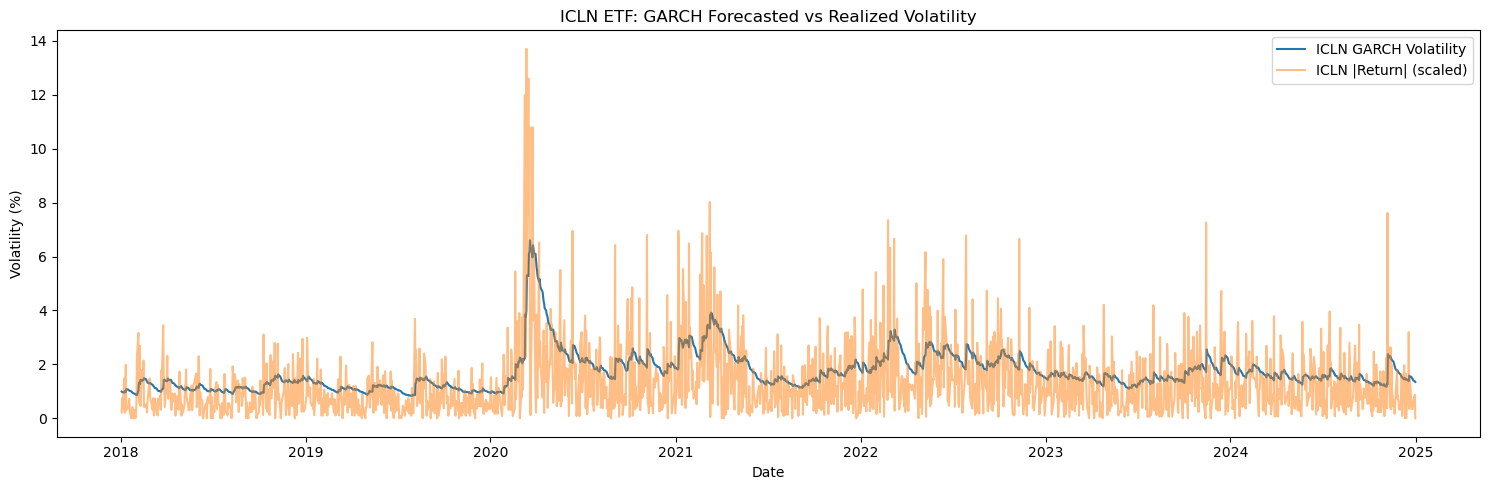

Fitting GARCH(1,1) for XLE...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:            xle_xle_ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3422.48
Distribution:                  Normal   AIC:                           6850.96
Method:            Maximum Likelihood   BIC:                           6867.38
                                        No. Observations:                 1763
Date:                Sun, Jun 15 2025   Df Residuals:                     1763
Time:                        13:09:09   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0474  2.130

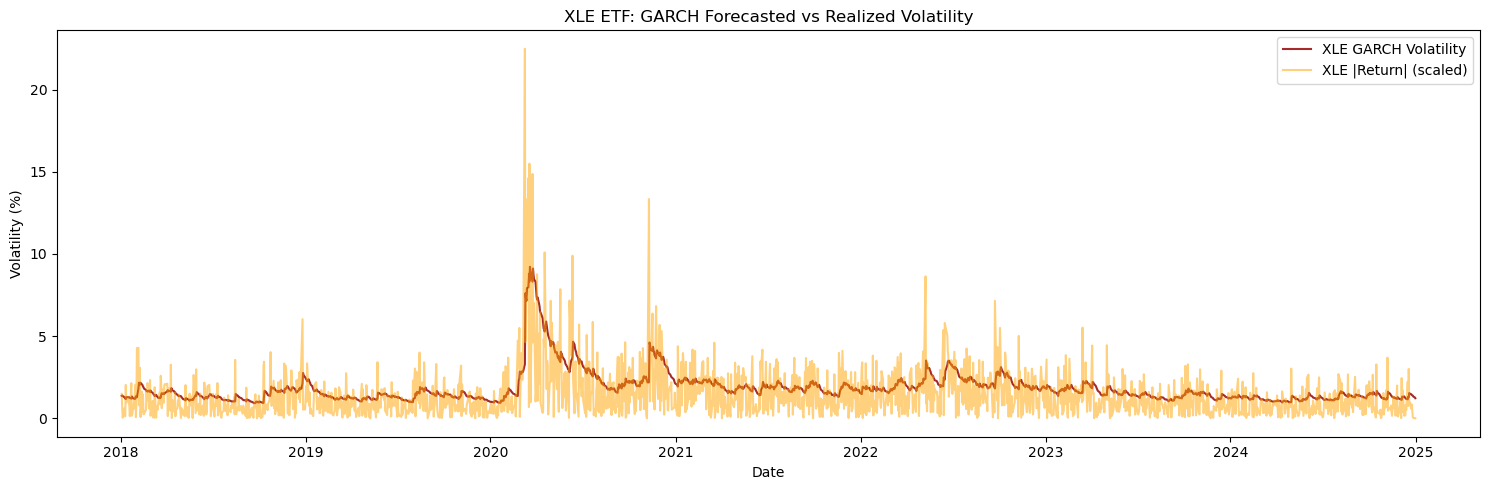

In [2]:
# Load your (already returns- and vol-augmented) dataset
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_returns_shocks_vol_2018_2024.csv', index_col=0, parse_dates=True)

def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()

df.columns = [clean_col(col) for col in df.columns]
print("Cleaned columns:", list(df.columns))

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

icln_ret_col = find_col('icln_ret', df.columns)
xle_ret_col  = find_col('xle_ret', df.columns)
carbon_shock_col = find_col('carbon_shock', df.columns)

print("\nDetected columns:")
for name, val in [
    ('icln_ret_col', icln_ret_col), ('xle_ret_col', xle_ret_col), ('carbon_shock_col', carbon_shock_col)
]:
    print(f"{name}: {val}")

# ----- GARCH for ICLN (Green ETF) -----
if icln_ret_col:
    returns_icln = df[icln_ret_col].dropna() * 100  # scale for GARCH
    print("Fitting GARCH(1,1) for ICLN...")
    garch_icln = arch_model(returns_icln, vol='Garch', p=1, q=1, mean='Zero', rescale=False)
    garch_result_icln = garch_icln.fit(disp='off')
    print(garch_result_icln.summary())
    df.loc[returns_icln.index, 'icln_garch_vol'] = garch_result_icln.conditional_volatility

    plt.figure(figsize=(15,5))
    plt.plot(df.loc[returns_icln.index].index, df.loc[returns_icln.index, 'icln_garch_vol'], label='ICLN GARCH Volatility')
    plt.plot(df.loc[returns_icln.index].index, np.abs(returns_icln), label='ICLN |Return| (scaled)', alpha=0.5)
    plt.title('ICLN ETF: GARCH Forecasted vs Realized Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("ICLN return column not found—skipping GARCH for ICLN.")

# ----- GARCH for XLE (Brown ETF) -----
if xle_ret_col:
    returns_xle = df[xle_ret_col].dropna() * 100
    print("Fitting GARCH(1,1) for XLE...")
    garch_xle = arch_model(returns_xle, vol='Garch', p=1, q=1, mean='Zero', rescale=False)
    garch_result_xle = garch_xle.fit(disp='off')
    print(garch_result_xle.summary())
    df.loc[returns_xle.index, 'xle_garch_vol'] = garch_result_xle.conditional_volatility

    plt.figure(figsize=(15,5))
    plt.plot(df.loc[returns_xle.index].index, df.loc[returns_xle.index, 'xle_garch_vol'], label='XLE GARCH Volatility', color='brown')
    plt.plot(df.loc[returns_xle.index].index, np.abs(returns_xle), label='XLE |Return| (scaled)', alpha=0.5, color='orange')
    plt.title('XLE ETF: GARCH Forecasted vs Realized Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("XLE return column not found—skipping GARCH for XLE.")

# ------------------------------------------------------------



ICLN Out-of-sample forecast errors (last 20%):
GARCH:   RMSE = 0.3258, MAE = 0.2539
Rolling: RMSE = 0.2137, MAE = 0.1190

XLE Out-of-sample forecast errors (last 20%):
GARCH:   RMSE = 0.2480, MAE = 0.2008
Rolling: RMSE = 0.1463, MAE = 0.0945


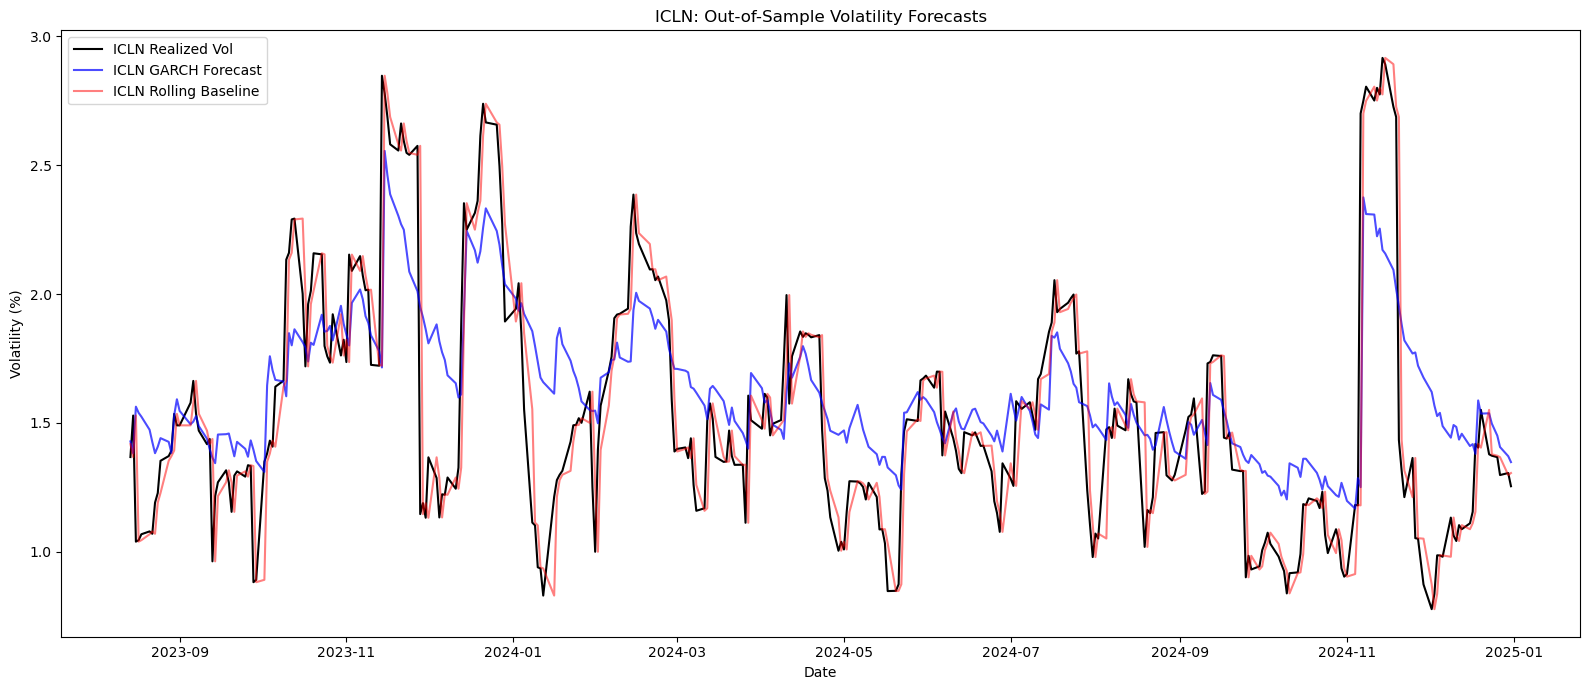

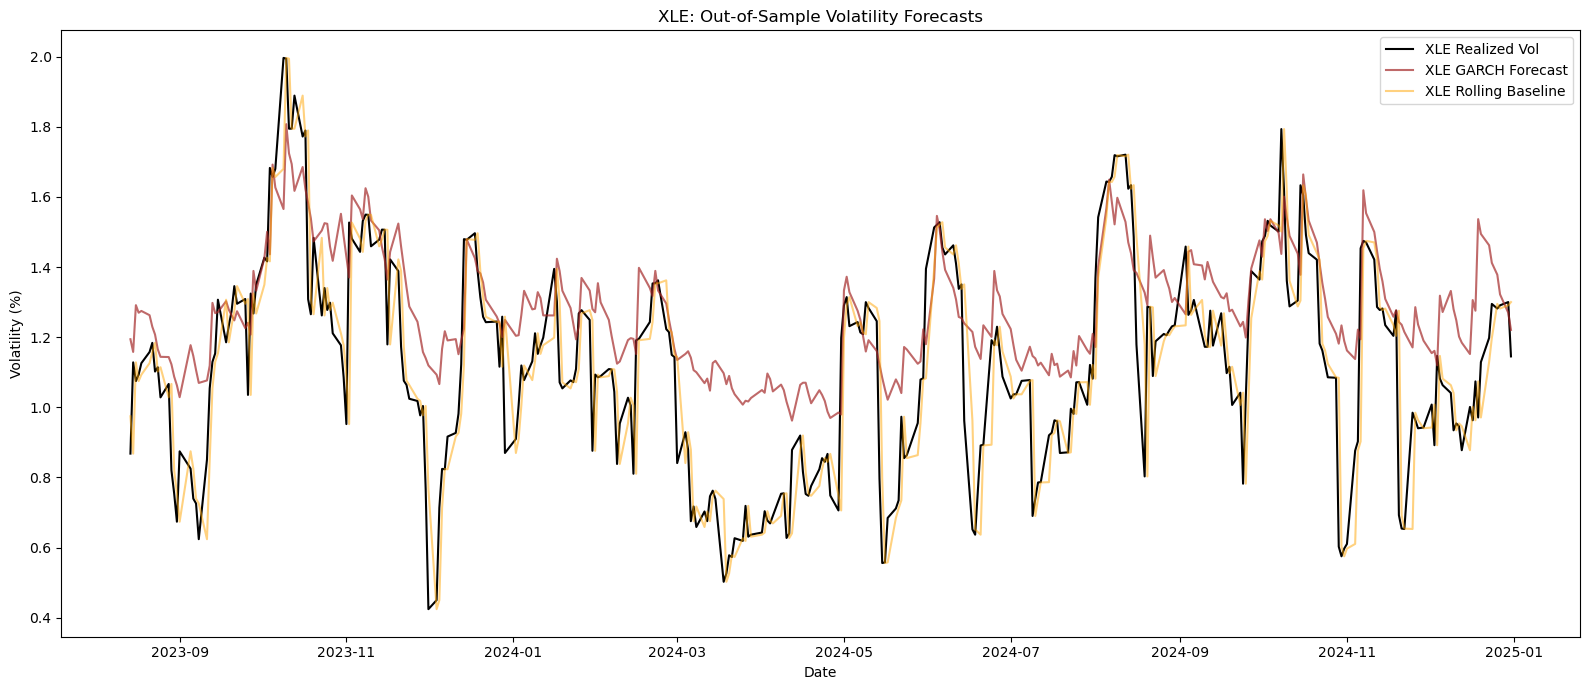

In [8]:
# Load the dataset with GARCH forecasts
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_garch_2018_2024.csv', index_col=0, parse_dates=True)

# Robustly find return and GARCH volatility columns
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

icln_ret_col = find_col('ICLN_ret', df.columns)
xle_ret_col  = find_col('XLE_ret', df.columns)
icln_garch_vol_col = find_col('icln_garch_vol', df.columns)
xle_garch_vol_col  = find_col('xle_garch_vol', df.columns)

window = 10

# ---- Prepare realized and baseline volatility for both ETFs ----
df['icln_realized_vol'] = df[icln_ret_col].rolling(window=window).std() * 100
df['icln_baseline_vol'] = df['icln_realized_vol'].shift(1)

df['xle_realized_vol'] = df[xle_ret_col].rolling(window=window).std() * 100
df['xle_baseline_vol'] = df['xle_realized_vol'].shift(1)

# Drop rows with missing data for both ETFs
eval_icln = df[[icln_garch_vol_col, 'icln_baseline_vol', 'icln_realized_vol']].dropna()
eval_xle  = df[[xle_garch_vol_col,  'xle_baseline_vol',  'xle_realized_vol']].dropna()

# Use last 20% as test set
test_size_icln = int(len(eval_icln) * 0.2)
test_size_xle  = int(len(eval_xle)  * 0.2)
test_icln = eval_icln.iloc[-test_size_icln:]
test_xle  = eval_xle.iloc[-test_size_xle:]

# ---- ICLN: Calculate errors ----
rmse_garch_icln = np.sqrt(mean_squared_error(test_icln['icln_realized_vol'], test_icln[icln_garch_vol_col]))
mae_garch_icln  = mean_absolute_error(test_icln['icln_realized_vol'], test_icln[icln_garch_vol_col])

rmse_base_icln = np.sqrt(mean_squared_error(test_icln['icln_realized_vol'], test_icln['icln_baseline_vol']))
mae_base_icln  = mean_absolute_error(test_icln['icln_realized_vol'], test_icln['icln_baseline_vol'])

print("\nICLN Out-of-sample forecast errors (last 20%):")
print(f"GARCH:   RMSE = {rmse_garch_icln:.4f}, MAE = {mae_garch_icln:.4f}")
print(f"Rolling: RMSE = {rmse_base_icln:.4f}, MAE = {mae_base_icln:.4f}")

# ---- XLE: Calculate errors ----
rmse_garch_xle = np.sqrt(mean_squared_error(test_xle['xle_realized_vol'], test_xle[xle_garch_vol_col]))
mae_garch_xle  = mean_absolute_error(test_xle['xle_realized_vol'], test_xle[xle_garch_vol_col])

rmse_base_xle = np.sqrt(mean_squared_error(test_xle['xle_realized_vol'], test_xle['xle_baseline_vol']))
mae_base_xle  = mean_absolute_error(test_xle['xle_realized_vol'], test_xle['xle_baseline_vol'])

print("\nXLE Out-of-sample forecast errors (last 20%):")
print(f"GARCH:   RMSE = {rmse_garch_xle:.4f}, MAE = {mae_garch_xle:.4f}")
print(f"Rolling: RMSE = {rmse_base_xle:.4f}, MAE = {mae_base_xle:.4f}")

# ---- Plot ICLN forecasts ----
plt.figure(figsize=(16,7))
plt.plot(test_icln.index, test_icln['icln_realized_vol'], label='ICLN Realized Vol', color='black')
plt.plot(test_icln.index, test_icln[icln_garch_vol_col], label='ICLN GARCH Forecast', color='blue', alpha=0.7)
plt.plot(test_icln.index, test_icln['icln_baseline_vol'], label='ICLN Rolling Baseline', color='red', alpha=0.5)
plt.title('ICLN: Out-of-Sample Volatility Forecasts')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot XLE forecasts ----
plt.figure(figsize=(16,7))
plt.plot(test_xle.index, test_xle['xle_realized_vol'], label='XLE Realized Vol', color='black')
plt.plot(test_xle.index, test_xle[xle_garch_vol_col], label='XLE GARCH Forecast', color='brown', alpha=0.7)
plt.plot(test_xle.index, test_xle['xle_baseline_vol'], label='XLE Rolling Baseline', color='orange', alpha=0.5)
plt.title('XLE: Out-of-Sample Volatility Forecasts')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.tight_layout()
plt.show()

Training LSTM model for ICLN volatility forecasting...
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130 
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015  
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014    
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014  
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013  
Epoch 12/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012   
Epoch 13/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012  
Epoch 14/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011
Epoch 15/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8557e

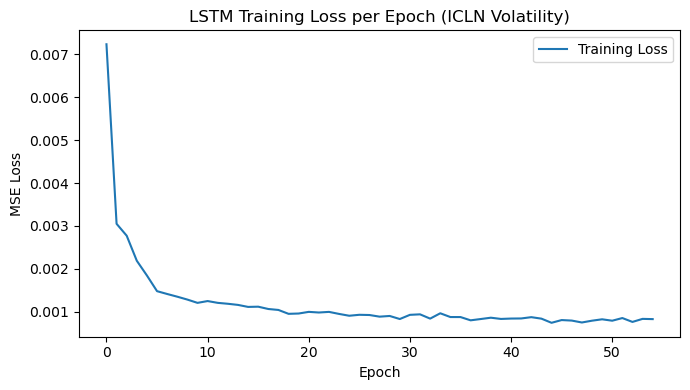

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

ICLN LSTM out-of-sample errors:
LSTM:  RMSE = 0.2166, MAE = 0.1291
GARCH: RMSE = 0.3262, MAE = 0.2544


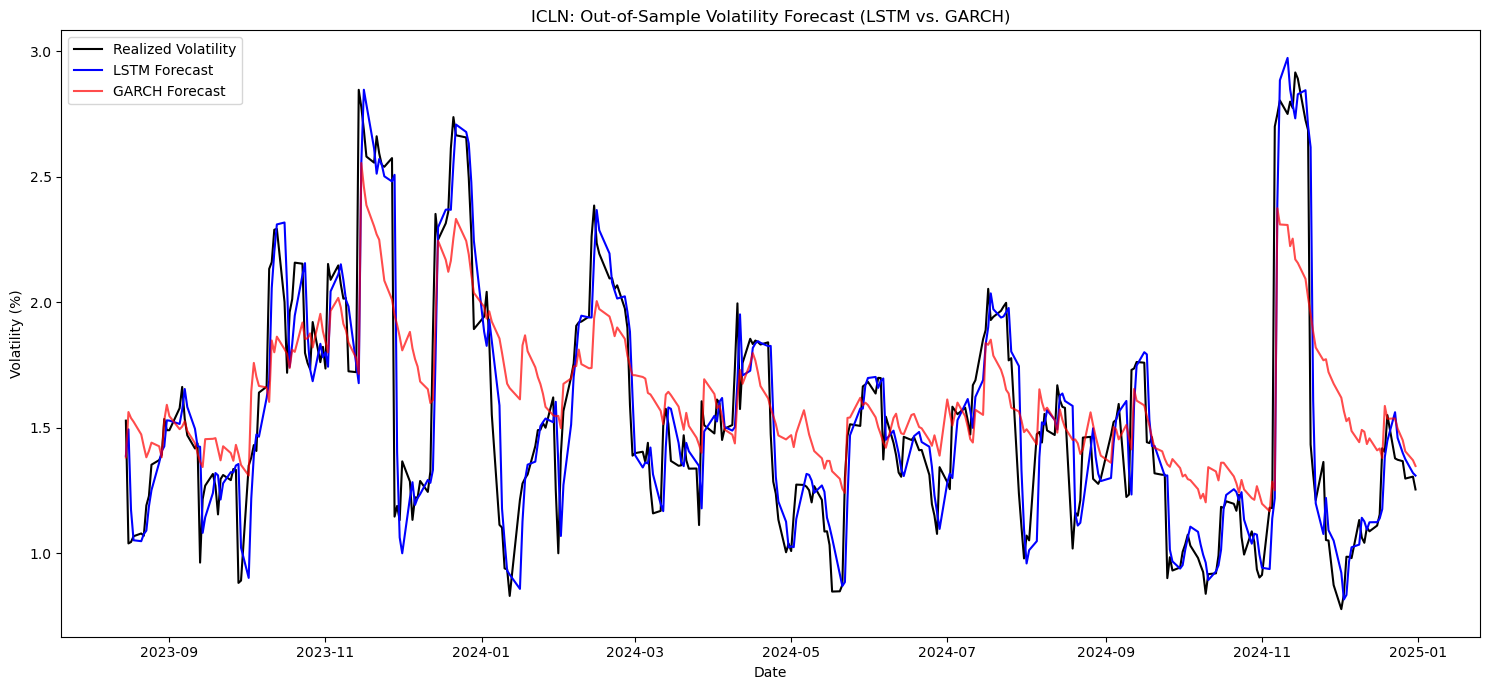

In [12]:
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_garch_2018_2024.csv', index_col=0, parse_dates=True)

# Robust column finding
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

icln_ret_col = find_col('ICLN_ret', df.columns)
garch_vol_col = find_col('icln_garch_vol', df.columns)

# Prepare volatility target (realized 10-day rolling std, scaled to %)
window = 10
df['icln_realized_vol'] = df[icln_ret_col].rolling(window=window).std() * 100

# Drop NA for modeling
df_ml = df[['icln_realized_vol', garch_vol_col]].dropna().copy()

# Prepare lagged features for time series (past N lags to predict next volatility)
N_LAGS = 10
features = []
targets = []

for i in range(N_LAGS, len(df_ml)):
    features.append(df_ml['icln_realized_vol'].iloc[i-N_LAGS:i].values)
    targets.append(df_ml['icln_realized_vol'].iloc[i])

features = np.array(features)
targets = np.array(targets).reshape(-1,1)

# Scale features & targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)
targets_scaled = scaler_y.fit_transform(targets)

# Split into train/test
split_idx = int(len(features_scaled)*0.8)
X_train, X_test = features_scaled[:split_idx], features_scaled[split_idx:]
y_train, y_test = targets_scaled[:split_idx], targets_scaled[split_idx:]

# LSTM expects [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], N_LAGS, 1))
X_test  = X_test.reshape((X_test.shape[0], N_LAGS, 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(N_LAGS, 1), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Set up early stopping
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train model for up to 100 epochs, with early stopping
print("Training LSTM model for ICLN volatility forecasting...")
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    verbose=1,
    callbacks=[early_stop]
)

# Plot the training loss curve
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training Loss per Epoch (ICLN Volatility)')
plt.legend()
plt.tight_layout()
plt.show()

# Forecast
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# Match dates
test_dates = df_ml.index[N_LAGS+split_idx:]

# GARCH for same dates
garch_for_test = df_ml[garch_vol_col].iloc[N_LAGS+split_idx:].values

# Compute errors
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae_lstm  = mean_absolute_error(y_test_inv, y_pred)
rmse_garch = np.sqrt(mean_squared_error(y_test_inv, garch_for_test))
mae_garch  = mean_absolute_error(y_test_inv, garch_for_test)

print("\nICLN LSTM out-of-sample errors:")
print(f"LSTM:  RMSE = {rmse_lstm:.4f}, MAE = {mae_lstm:.4f}")
print(f"GARCH: RMSE = {rmse_garch:.4f}, MAE = {mae_garch:.4f}")

# Plot forecast results
plt.figure(figsize=(15,7))
plt.plot(test_dates, y_test_inv, label='Realized Volatility', color='black')
plt.plot(test_dates, y_pred, label='LSTM Forecast', color='blue')
plt.plot(test_dates, garch_for_test, label='GARCH Forecast', color='red', alpha=0.7)
plt.title('ICLN: Out-of-Sample Volatility Forecast (LSTM vs. GARCH)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.tight_layout()
plt.show()

Training LSTM model for XLE volatility forecasting...
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0168  
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026   
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016   
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016   
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013  
Epoch 12/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011   
Epoch 13/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010   
Epoch 14/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013   
Epoch 15/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0

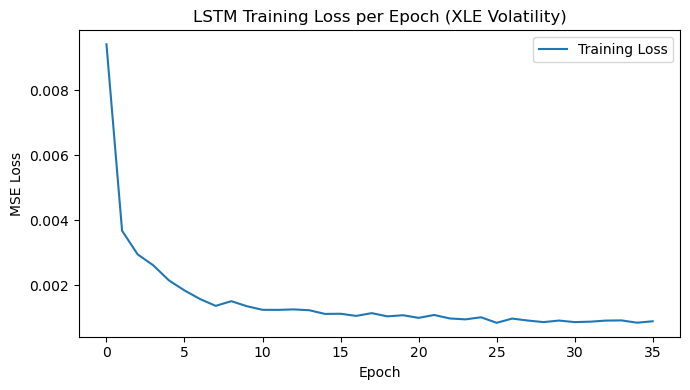

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

XLE LSTM out-of-sample errors:
LSTM:  RMSE = 0.1714, MAE = 0.1269
GARCH: RMSE = 0.2477, MAE = 0.2004


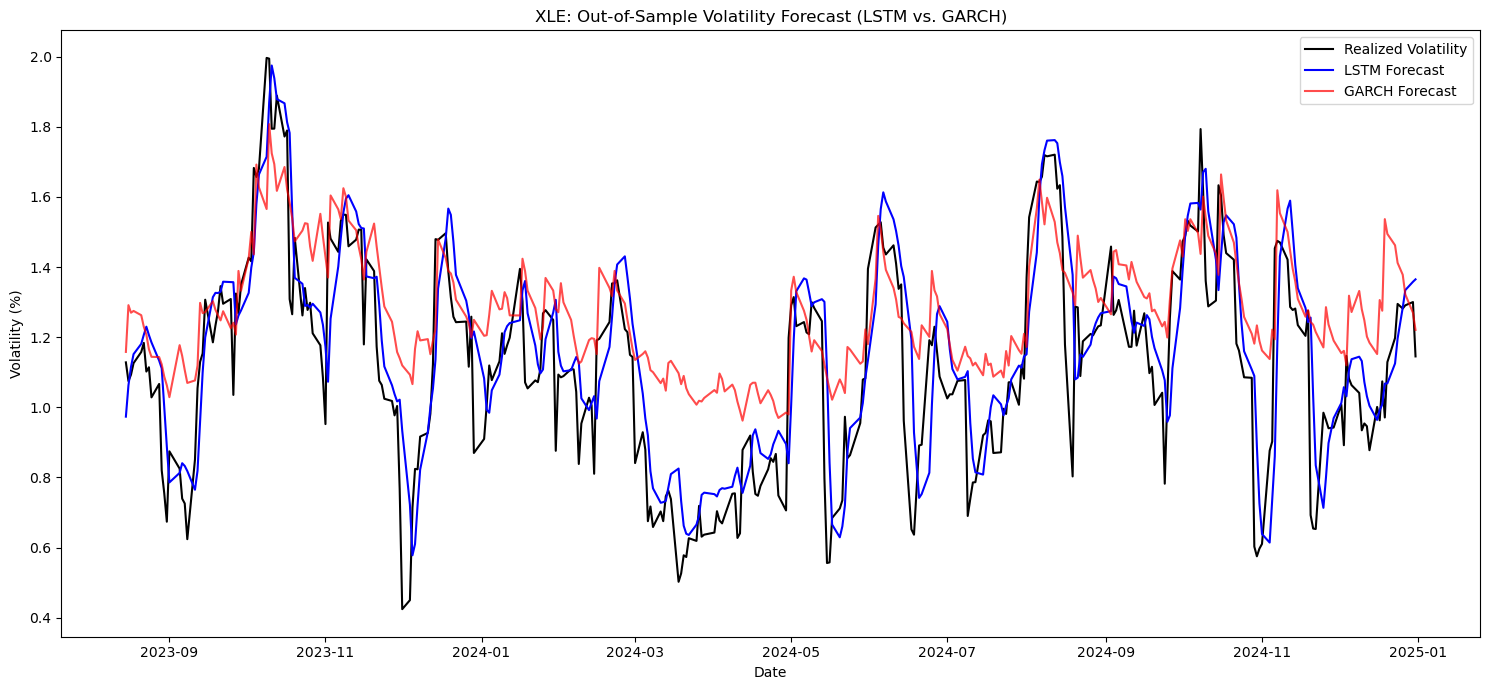

In [14]:
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_garch_2018_2024.csv', index_col=0, parse_dates=True)

# Robust column finding
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

xle_ret_col = find_col('XLE_ret', df.columns)
garch_vol_col = find_col('xle_garch_vol', df.columns)

# Prepare volatility target (realized 10-day rolling std, scaled to %)
window = 10
df['xle_realized_vol'] = df[xle_ret_col].rolling(window=window).std() * 100

# Drop NA for modeling
df_ml = df[['xle_realized_vol', garch_vol_col]].dropna().copy()

# Prepare lagged features for time series (past N lags to predict next volatility)
N_LAGS = 10
features = []
targets = []

for i in range(N_LAGS, len(df_ml)):
    features.append(df_ml['xle_realized_vol'].iloc[i-N_LAGS:i].values)
    targets.append(df_ml['xle_realized_vol'].iloc[i])

features = np.array(features)
targets = np.array(targets).reshape(-1,1)

# Scale features & targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)
targets_scaled = scaler_y.fit_transform(targets)

# Split into train/test
split_idx = int(len(features_scaled)*0.8)
X_train, X_test = features_scaled[:split_idx], features_scaled[split_idx:]
y_train, y_test = targets_scaled[:split_idx], targets_scaled[split_idx:]

# LSTM expects [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], N_LAGS, 1))
X_test  = X_test.reshape((X_test.shape[0], N_LAGS, 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(N_LAGS, 1), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Set up early stopping
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train model for up to 100 epochs, with early stopping
print("Training LSTM model for XLE volatility forecasting...")
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    verbose=1,
    callbacks=[early_stop]
)

# Plot the training loss curve
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training Loss per Epoch (XLE Volatility)')
plt.legend()
plt.tight_layout()
plt.show()

# Forecast
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# Match dates
test_dates = df_ml.index[N_LAGS+split_idx:]

# GARCH for same dates
garch_for_test = df_ml[garch_vol_col].iloc[N_LAGS+split_idx:].values

# Compute errors
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae_lstm  = mean_absolute_error(y_test_inv, y_pred)
rmse_garch = np.sqrt(mean_squared_error(y_test_inv, garch_for_test))
mae_garch  = mean_absolute_error(y_test_inv, garch_for_test)

print("\nXLE LSTM out-of-sample errors:")
print(f"LSTM:  RMSE = {rmse_lstm:.4f}, MAE = {mae_lstm:.4f}")
print(f"GARCH: RMSE = {rmse_garch:.4f}, MAE = {mae_garch:.4f}")

# Plot forecast results
plt.figure(figsize=(15,7))
plt.plot(test_dates, y_test_inv, label='Realized Volatility', color='black')
plt.plot(test_dates, y_pred, label='LSTM Forecast', color='blue')
plt.plot(test_dates, garch_for_test, label='GARCH Forecast', color='red', alpha=0.7)
plt.title('XLE: Out-of-Sample Volatility Forecast (LSTM vs. GARCH)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 


Model Out-of-Sample Error Metrics (Volatility):
    ETF  Model      RMSE       MAE
0  ICLN   LSTM  0.217619  0.129023
1  ICLN  GARCH  0.326244  0.254432
2   XLE   LSTM  0.159997  0.115538
3   XLE  GARCH  0.247715  0.200415


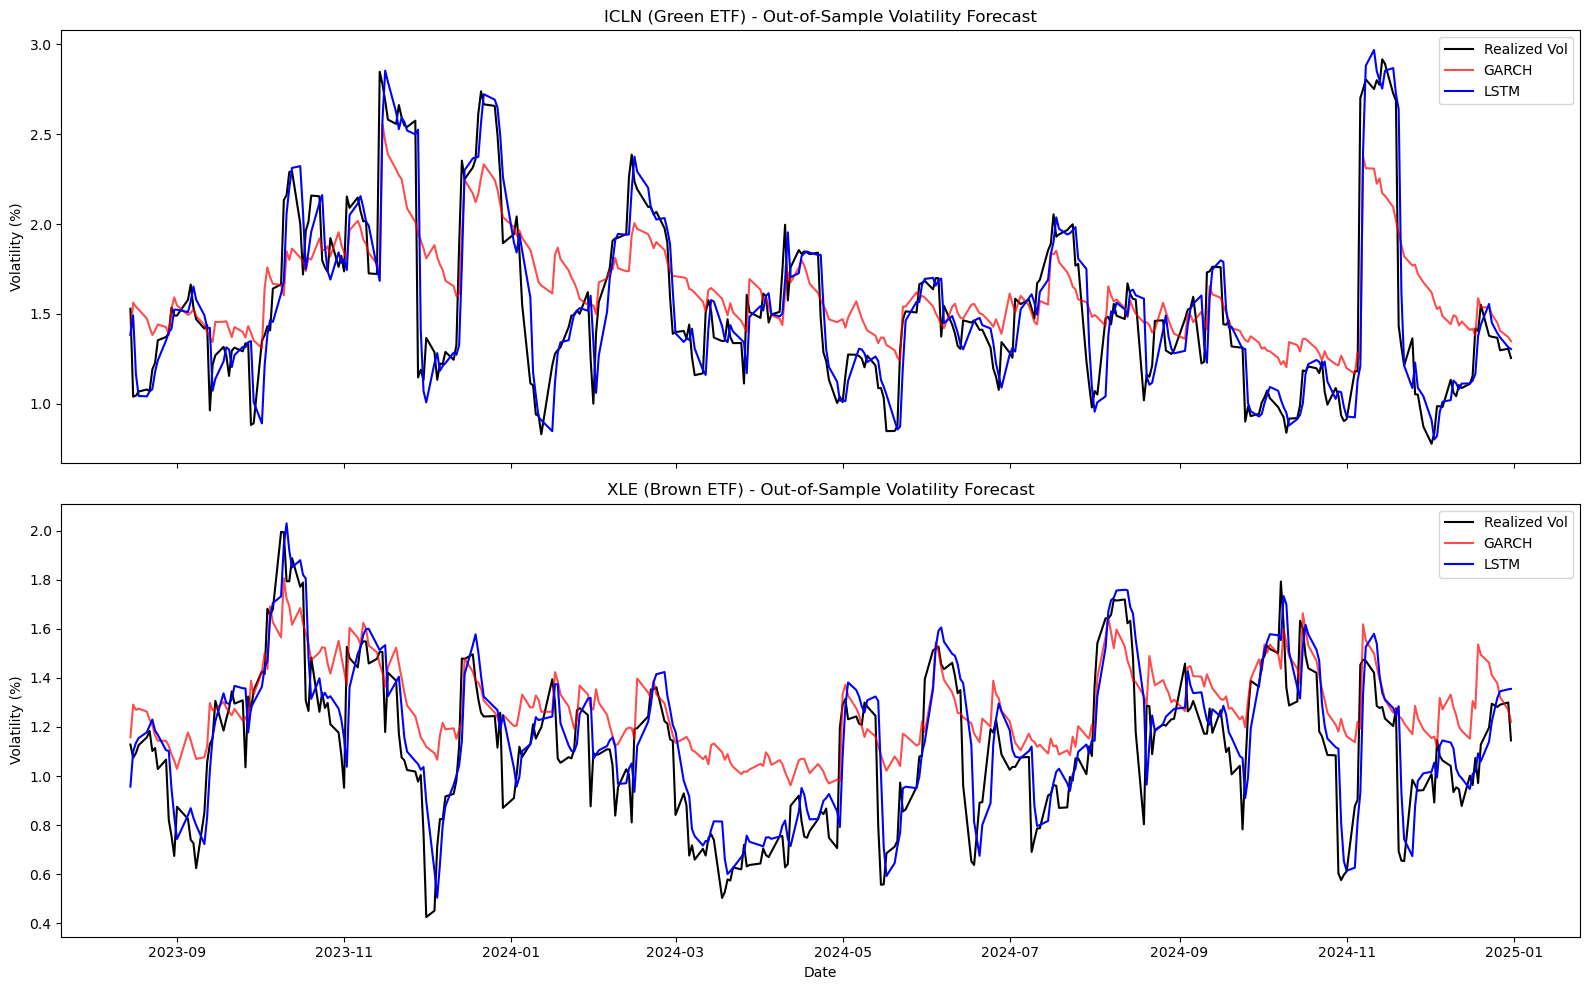

In [18]:

# Load results
icln_res = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/icln_volatility_forecast_lstm_vs_garch.csv', parse_dates=['date'], index_col='date')
xle_res  = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/xle_volatility_forecast_lstm_vs_garch.csv', parse_dates=['date'], index_col='date')

# Compute metrics for ICLN
rmse_lstm_icln = mean_squared_error(icln_res['realized_vol'], icln_res['lstm_forecast'], squared=False)
mae_lstm_icln  = mean_absolute_error(icln_res['realized_vol'], icln_res['lstm_forecast'])
rmse_garch_icln = mean_squared_error(icln_res['realized_vol'], icln_res['garch_forecast'], squared=False)
mae_garch_icln  = mean_absolute_error(icln_res['realized_vol'], icln_res['garch_forecast'])

# Compute metrics for XLE
rmse_lstm_xle = mean_squared_error(xle_res['realized_vol'], xle_res['lstm_forecast'], squared=False)
mae_lstm_xle  = mean_absolute_error(xle_res['realized_vol'], xle_res['lstm_forecast'])
rmse_garch_xle = mean_squared_error(xle_res['realized_vol'], xle_res['garch_forecast'], squared=False)
mae_garch_xle  = mean_absolute_error(xle_res['realized_vol'], xle_res['garch_forecast'])

# Make summary table
summary = pd.DataFrame({
    'ETF': ['ICLN', 'ICLN', 'XLE', 'XLE'],
    'Model': ['LSTM', 'GARCH', 'LSTM', 'GARCH'],
    'RMSE': [rmse_lstm_icln, rmse_garch_icln, rmse_lstm_xle, rmse_garch_xle],
    'MAE': [mae_lstm_icln, mae_garch_icln, mae_lstm_xle, mae_garch_xle]
})
print("\nModel Out-of-Sample Error Metrics (Volatility):")
print(summary)

ig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

axes[0].plot(icln_res.index, icln_res['realized_vol'], label='Realized Vol', color='black')
axes[0].plot(icln_res.index, icln_res['garch_forecast'], label='GARCH', color='red', alpha=0.7)
axes[0].plot(icln_res.index, icln_res['lstm_forecast'], label='LSTM', color='blue')
axes[0].set_title('ICLN (Green ETF) - Out-of-Sample Volatility Forecast')
axes[0].set_ylabel('Volatility (%)')
axes[0].legend()

axes[1].plot(xle_res.index, xle_res['realized_vol'], label='Realized Vol', color='black')
axes[1].plot(xle_res.index, xle_res['garch_forecast'], label='GARCH', color='red', alpha=0.7)
axes[1].plot(xle_res.index, xle_res['lstm_forecast'], label='LSTM', color='blue')
axes[1].set_title('XLE (Brown ETF) - Out-of-Sample Volatility Forecast')
axes[1].set_ylabel('Volatility (%)')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.show()

Detected columns for visualization:
icln_ret_col: icln_icln_ret
xle_ret_col: xle_xle_ret
carbon_col: carbon_eua
icln_vol_col: icln_vol
xle_vol_col: xle_vol
carbon_shock_col: carbon_shock_resid

Number of carbon shock days: 0
Sample shock dates: DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)
ICLN returns NaN at shock dates: 0 out of 0
ICLN volatility NaN at shock dates: 0 out of 0


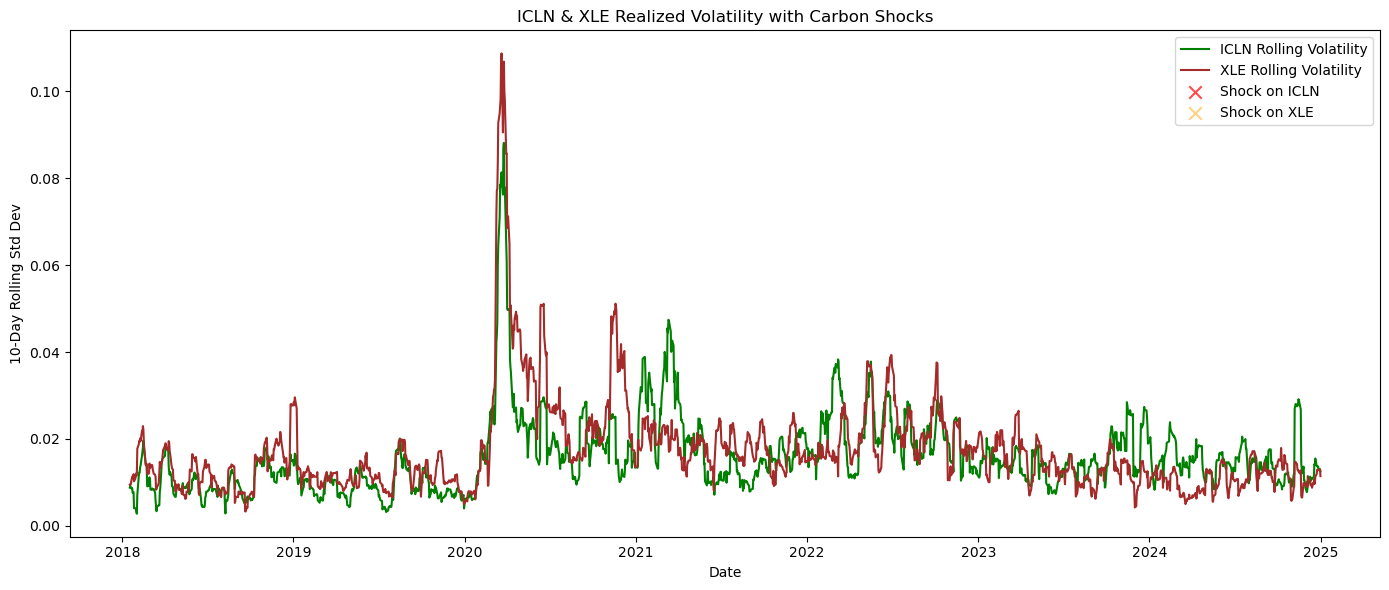

In [20]:
csv_path = '/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_garch_2018_2024.csv'
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()

df.columns = [clean_col(col) for col in df.columns]

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

# Detect columns robustly
icln_ret_col = find_col('icln_ret', df.columns)
xle_ret_col = find_col('xle_ret', df.columns)
carbon_col = find_col('carbon_eua', df.columns)
icln_vol_col = find_col('icln_vol', df.columns)
xle_vol_col = find_col('xle_vol', df.columns)
carbon_shock_col = find_col('carbon_shock', df.columns)

# --- If only the residual is present, create the shock flag now ---
if not carbon_shock_col:
    resid_col = find_col('carbon_shock_resid', df.columns)
    if resid_col:
        resid = df[resid_col]
        threshold = 1.5 * np.nanstd(resid)
        df['carbon_shock'] = (resid.abs() > threshold).astype(int)
        carbon_shock_col = 'carbon_shock'
        print(f"Auto-created carbon_shock column: {df['carbon_shock'].sum()} shocks (threshold={threshold:.4f})")
        # Save for future steps
        df.to_csv(csv_path)
    else:
        print("No carbon shock residual or flag found; cannot plot shocks.")
        carbon_shock_col = None

print("Detected columns for visualization:")
for name, val in [
    ('icln_ret_col', icln_ret_col),
    ('xle_ret_col', xle_ret_col),
    ('carbon_col', carbon_col),
    ('icln_vol_col', icln_vol_col),
    ('xle_vol_col', xle_vol_col),
    ('carbon_shock_col', carbon_shock_col)
]:
    print(f"{name}: {val}")

# --- Calculate shock_dates and debug print ---
if carbon_shock_col:
    shock_dates = df.index[df[carbon_shock_col] == 1]
    print(f"\nNumber of carbon shock days: {len(shock_dates)}")
    print("Sample shock dates:", shock_dates[:10])
    if icln_ret_col:
        nan_count = df.loc[shock_dates, icln_ret_col].isnull().sum()
        print(f"ICLN returns NaN at shock dates: {nan_count} out of {len(shock_dates)}")
    if icln_vol_col:
        nan_vol_count = df.loc[shock_dates, icln_vol_col].isnull().sum()
        print(f"ICLN volatility NaN at shock dates: {nan_vol_count} out of {len(shock_dates)}")
else:
    shock_dates = []
plt.figure(figsize=(14,6))
if icln_vol_col:
    plt.plot(df.index, df[icln_vol_col], label='ICLN Rolling Volatility', color='green')
if xle_vol_col:
    plt.plot(df.index, df[xle_vol_col], label='XLE Rolling Volatility', color='brown')
if carbon_shock_col and icln_vol_col:
    plt.scatter(shock_dates, df.loc[shock_dates, icln_vol_col], 
                color='red', marker='x', label='Shock on ICLN', alpha=0.7, s=80, zorder=10)
if carbon_shock_col and xle_vol_col:
    plt.scatter(shock_dates, df.loc[shock_dates, xle_vol_col], 
                color='orange', marker='x', label='Shock on XLE', alpha=0.5, s=80, zorder=10)
plt.title('ICLN & XLE Realized Volatility with Carbon Shocks')
plt.xlabel('Date')
plt.ylabel('10-Day Rolling Std Dev')
plt.legend()
plt.tight_layout()
plt.show()